<a href="https://colab.research.google.com/github/Sanford-Lab/satellite_cnns/blob/train-functionality/benin_apache_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is based on the tutorial for [land cover classification.](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb#scrollTo=D8Kwmqa8CpQV) and [weather forcasting](https://github.com/GoogleCloudPlatform/python-docs-samples/tree/main/people-and-planet-ai/weather-forecasting).

Our current objective is to prepare a dataset of Benin which will be used to train a model to predict which pixels belong to a village. We wish to take in the feature collection from 'projects/ls-test-3-24/assets/voronoi_villages' which has circles around villages in Benin and use this as a target for prediction. As input, we wish to use landsat 7 imagery of Benin.

The notebook has the sections:


1.   Setup
2.   Pull defined functions for dataset creation and sampling
3.   Create pipeline and do data export
4. Read data

Sections 1-2 closely follow the tutorial notebook and appear to be working. Section 3 has been updated to follow the weather forcasting sample by using compressed NumPy files instead of TFrecord files.

dd: **Moved change notes to [CHANGELOG.md](CHANGELOG.md)**




# Setup

In [1]:
%rm -r /content/satellite_cnns
%cd /content

rm: cannot remove '/content/satellite_cnns': No such file or directory
/content


In [2]:
branch = "train-functionality"

In [3]:
# Clone from SPIRES Repo
!git clone --branch {branch} https://github.com/Sanford-Lab/satellite_cnns.git
%cd /content/satellite_cnns

Cloning into 'satellite_cnns'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 420 (delta 27), reused 35 (delta 17), pack-reused 324
Receiving objects: 100% (420/420), 4.19 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (202/202), done.
/content/satellite_cnns


**New**: The notebook now sources files from the Sanford-Lab/satellite_cnns repo. For this notebook, it will use the `benin-data` package. It's built it based on the weather-forcasting notebook patterns and to allow importing for project-specific packages to *plug and play* for data creation. The new patterns should allow the workflow to be much more modular. All a new project would need to do is define 3 main functions `get_inputs_image`, `get_labels_image`, and `sample_points`. The create_dataset.py script should then be able to synthesize the dataset through abstraction. I've kept most of the demonstration functionality the same to show how using the package works.

In [4]:
!pip install --quiet --upgrade pip

# We need `build` and `virtualenv` to build the local packages.
!pip install --quiet build virtualenv

# Install Apache Beam and the `benin-data` local package.
!pip install apache-beam[gcp] src/benin-data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 25.3 MB/s eta 0:00:00
Processing ./src/benin-data
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.9/648.9 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# run to manually restart runtime by ending process
# exit()

At this point runtime is restarted. Navigate back to our working directory.

In [6]:
%cd /content/satellite_cnns

/content/satellite_cnns


In [7]:
#@title Project settings
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "ls-test-3-24" #@param {type:"string"}
bucket = "benin-bucket1" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"
assert bucket, "⚠️ Please provide a Cloud Storage bucket name"
assert not bucket.startswith('gs://'), f"⚠️ Please remove the gs:// prefix from the bucket name: {bucket}"
assert location, "⚠️ Please provide a Google Cloud location"

# Authenticate to Colab.
auth.authenticate_user()

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ['GOOGLE_CLOUD_PROJECT'] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [8]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

# Define functions for dataset creation

This section generally follows the tutorial notebook. In the end, we wish for the inputs to be LANDSAT 7 data of Benin. We select R, G, B, and NDVI bands for the input data. As labels, we wish to prepare a binary image with a target label of 1 if pixel belongs to a village and a 0 if it does not belong to a village. The village circles are specified in a feature collection available at: 'projects/ls-test-3-24/assets/voronoi_villages'

Based on our visulizations with folium at the end, this section appears to be working fine.

**dd_NEW**: To utilize the new package data, I replaced the function definitions in the notebook with their imports from the package. You can see the function declarations here:

> <button>
>
> [![Open in GitHub](https://www.tensorflow.org/images/GitHub-Mark-32px.png) `benin/data.py`](src/benin-data/benin/data.py)
> </button>

In this next code chunk, we prepare the inputs and label images.

In [ ]:
from benin.data import get_inputs_image

In [ ]:
from benin.data import get_labels_image

## Visualize the input and target

In [ ]:
#Visualize the target. White circles are inside villages, black circles are outside villages
import folium

mapid = get_labels_image().getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[9.8, 2.4], zoom_start = 7)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='target variable',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
# view the first three bands of the features
image = get_inputs_image()
vis_params = {
  "min": 0,
  "max": 3000,
  "bands": ["R", "G", "B"],
}
folium.Map(
    location=(9.8, 2.4),
    zoom_start=7,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

In [ ]:
bands = image.bandNames().getInfo()
print(f"Number of bands:{len(bands)}\nBands:")
for b in bands: print(f"{b}\t", end='')

Number of bands:4
Bands:
R	G	B	NDVI	

# Define functions for sampling points

The main functions: sample_points, get_patch, get_input_patch, get_label_patch, and get_training_example are all taken from the tutorial. For our data we have the classes "in village" and "not in village", and we perform stratified sampling in these villages. Based on our visualization at the end, this section appears to be working.

** dd_NEW ** Again, import the data package to use the benin-specific functions.

In [ ]:
from benin import data

for point in data.sample_points():
  print(point)

[2.474858607749282, 12.03293323078099]
[1.899936825912788, 7.325761141994698]
[2.241296633878206, 11.197500016549837]
[2.5826564418436244, 6.948468722664499]


To access the create_dataset script, we're going to enter the repo:

In [ ]:
from create_dataset import get_training_example

point = [1.9046529811544155, 6.937464360434035]
target = data.get_labels_image(as_double=True)
(inputs, labels) = get_training_example(point, patch_size = 128)
print(f"inputs : {inputs.dtype} {inputs.shape}")
print(f"labels : {labels.dtype} {labels.shape}")

inputs : float64 (128, 128, 4)
labels : float64 (128, 128, 1)


## Visualize a sampled patch

We can visualize how our `sample_points` and `get_training_example` functions work using the `show_patch` function from our `visualize.py` module.

The following code block shows how how `sample_points` generates two points inside and outside villages based on sampling params. RED is inside, BLUE is outside a village. Change the seed to get different sample points.

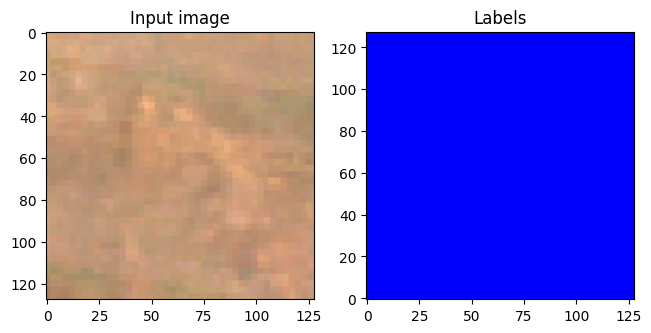

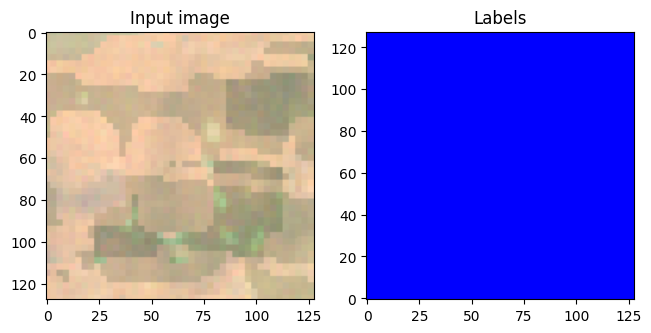

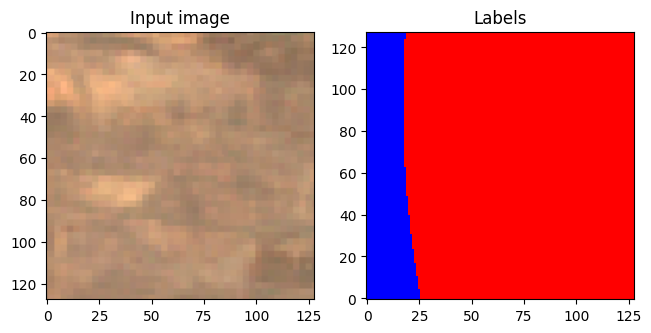

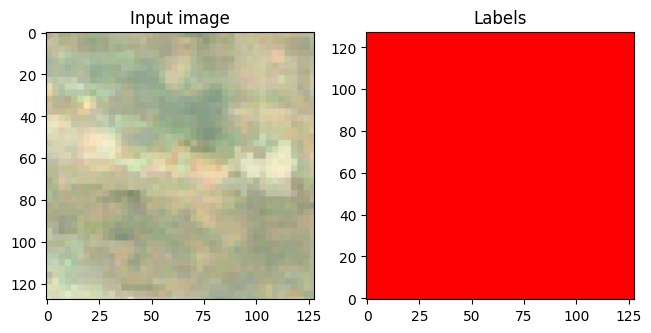

In [ ]:
from create_dataset import get_training_example
from visualize import show_patch

SEED = 0

# Print input and labels for sampling of 2 points per class
# (two points )
for point in data.sample_points(seed=SEED,points_per_class=2):
  (inputs, labels) = get_training_example(point, patch_size = 128)
  show_patch(inputs, labels)

In [ ]:
print(f'Image has dtype {inputs.dtype}')
print(f'Labels has dtype {labels.dtype}')

Image has dtype float64
Labels has dtype float64


# Create pipeline and do data export

Next we use an Apache-Beam pipeline to create and upload the training examples through
can create the NPZ files locally or through the distributed Dataflow runner.

## Define necessary functions for export

In [ ]:
PATCH_SIZE = 128
MAX_REQUESTS = 20
POINTS_PER_CLASS = 10 # small for testing purposes

## Run the pipeline locally

In [ ]:
data_path = "data/"

In [ ]:
#!pip install --quiet apache-beam[interactive]

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from benin.data import sample_points
from create_dataset import write_npz

beam_options = PipelineOptions([], direct_num_workers=1)
SEED = 0

with beam.Pipeline(options=beam_options) as pipeline:
  (
      pipeline
      | "🌱 Make seeds" >> beam.Create([0])
      | "📌 Sample points" >> beam.FlatMap(sample_points, points_per_class=POINTS_PER_CLASS)
      | "🃏 Reshuffle" >> beam.Reshuffle()
      | "🛰 Get examples" >> beam.Map(get_training_example, patch_size=PATCH_SIZE)
      | "🗂️ Batch examples" >> beam.BatchElements()
      | "📝 Write NPZ files" >> beam.Map(write_npz, data_path)
  )

View created files

In [ ]:
!ls -lh data

total 448K
-rw-r--r-- 1 root root 27K Jul  4 19:28 3b8a7ad6-d529-4cff-9321-2d3c942f5686.npz
-rw-r--r-- 1 root root 53K Jul  4 19:30 57d4fb81-d80c-46cf-af1f-c9ec2895cf9b.npz
-rw-r--r-- 1 root root 28K Jul  4 19:26 64ba81da-b685-4d83-977d-37e1a1237adf.npz
-rw-r--r-- 1 root root 27K Jul  4 19:31 6960576d-3fda-48f0-8349-289e6a4009c0.npz
-rw-r--r-- 1 root root 55K Jul  4 19:27 ada0b897-7dc4-4f4e-8971-7371296ee0b4.npz
-rw-r--r-- 1 root root 53K Jul  4 19:29 d4c15612-db9f-4999-b87e-3a894a85e8ab.npz
-rw-r--r-- 1 root root 54K Jul  4 19:28 e9fc60f6-a8a1-4ca3-8bdd-fc1e30f3c885.npz
-rw-r--r-- 1 root root 25K Jul  4 19:27 f4605d82-7972-4d5a-8f7b-557b4e70ed2d.npz
-rw-r--r-- 1 root root 28K Jul  4 19:30 f6175e39-2e34-4619-99ae-a40bd229e17c.npz
-rw-r--r-- 1 root root 25K Jul  4 19:29 f8b77fba-1c01-4c27-b5e3-db4d947d9bae.npz
-rw-r--r-- 1 root root 53K Jul  4 19:31 f97d7e9c-0b1f-4f40-944e-4c54d29f21ac.npz


In [ ]:
%rm -r data/

## Use the Distributed runner

To have a remote distributed runner complete the pipeline task, we created a script, `create_dataset.py` that will `run()` our pipeline based on arguments we can adjust. To do that, it needs acceess to the data package used, so we have to build it to give to Dataflow:

In [ ]:
# build benin data package to send to distributed runner
!python -m build src/benin-data

See the benin-data package

In [ ]:
!ls -lh src/benin-data/dist

total 16K
-rw-r--r-- 1 root root 4.4K Jul  4 19:38 benin_data-1.1.0-py3-none-any.whl
-rw-r--r-- 1 root root 4.1K Jul  4 19:37 benin-data-1.1.0.tar.gz


Define the GC data path for the exported files:

In [ ]:
bucket = 'example-bucket-ls-3-24'
folder = 'dd_test'
data_path=f"gs://{bucket}/{folder}/data"
print(data_path)

gs://example-bucket-ls-3-24/dd_test/data


Run the distributed runner (Dataflow):

In [ ]:
!python create_dataset.py \
  --data-path="gs://example-bucket-ls-3-24/dd_test/data" \
  --ppc="{POINTS_PER_CLASS}" \
  --runner="DataflowRunner" \
  --num-workers="5"\
  --project="{project}" \
  --region="{location}" \
  --temp_location="gs://example-bucket-ls-3-24/dd_test/temp" \
  --extra_package="./src/benin-data/dist/benin-data-1.1.0.tar.gz"

INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "tuple"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[tuple[np.ndarray, np.ndarray]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "str"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "str"
INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmpumlg7on0', 'apache-beam==2.48.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:Staging SDK sources from PyPI: dataflow_python_sdk.tar
INFO:apache_beam.runners.portability.stager:Downloading binary distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command:

In [ ]:
!gsutil ls -lh {data_path}

 24.89 KiB  2023-07-04T19:48:20Z  gs://example-bucket-ls-3-24/dd_test/data/04bf0834-90b1-4875-88db-7e32607cf45c.npz
 77.33 KiB  2023-07-04T19:45:01Z  gs://example-bucket-ls-3-24/dd_test/data/3702ead9-ac4f-4df5-8a34-55da0c7c5448.npz
 27.63 KiB  2023-07-04T19:49:06Z  gs://example-bucket-ls-3-24/dd_test/data/591afe2b-7402-49cc-ab69-b3c2302697c9.npz
105.07 KiB  2023-07-04T19:46:12Z  gs://example-bucket-ls-3-24/dd_test/data/6da70341-476c-4fce-8e4b-ba9524e9e65b.npz
 27.19 KiB  2023-07-04T19:48:41Z  gs://example-bucket-ls-3-24/dd_test/data/b21465c3-3d32-4c32-9955-9c112ec50d48.npz
 27.92 KiB  2023-07-04T19:43:08Z  gs://example-bucket-ls-3-24/dd_test/data/c1efb37c-b1ed-491f-b5bc-40880c68873c.npz
 155.6 KiB  2023-07-04T19:48:00Z  gs://example-bucket-ls-3-24/dd_test/data/dcfb4dd0-d197-41c5-bc22-e71de24a45b8.npz
 53.14 KiB  2023-07-04T19:44:04Z  gs://example-bucket-ls-3-24/dd_test/data/e92685da-16ba-4eb6-956b-44dbf6ef5c22.npz
 27.57 KiB  2023-07-04T19:43:27Z  gs://example-bucket-ls-3-24/dd_test/da

# Read data


Let's check Google Cloud Storage to see the files in GC

In [9]:
bucket = 'example-bucket-ls-3-24'
folder = 'dd_test'
data_path=f"gs://{bucket}/{folder}/data"
print(data_path)
!gsutil ls -lh {data_path}

gs://example-bucket-ls-3-24/dd_test/data
 24.89 KiB  2023-07-04T19:48:20Z  gs://example-bucket-ls-3-24/dd_test/data/04bf0834-90b1-4875-88db-7e32607cf45c.npz
 77.33 KiB  2023-07-04T19:45:01Z  gs://example-bucket-ls-3-24/dd_test/data/3702ead9-ac4f-4df5-8a34-55da0c7c5448.npz
 27.63 KiB  2023-07-04T19:49:06Z  gs://example-bucket-ls-3-24/dd_test/data/591afe2b-7402-49cc-ab69-b3c2302697c9.npz
105.07 KiB  2023-07-04T19:46:12Z  gs://example-bucket-ls-3-24/dd_test/data/6da70341-476c-4fce-8e4b-ba9524e9e65b.npz
 27.19 KiB  2023-07-04T19:48:41Z  gs://example-bucket-ls-3-24/dd_test/data/b21465c3-3d32-4c32-9955-9c112ec50d48.npz
 27.92 KiB  2023-07-04T19:43:08Z  gs://example-bucket-ls-3-24/dd_test/data/c1efb37c-b1ed-491f-b5bc-40880c68873c.npz
 155.6 KiB  2023-07-04T19:48:00Z  gs://example-bucket-ls-3-24/dd_test/data/dcfb4dd0-d197-41c5-bc22-e71de24a45b8.npz
 53.14 KiB  2023-07-04T19:44:04Z  gs://example-bucket-ls-3-24/dd_test/data/e92685da-16ba-4eb6-956b-44dbf6ef5c22.npz
 27.57 KiB  2023-07-04T19:43:27

Next, let's copy the files to a local directory to look at them

In [10]:
!mkdir -p data-training
!gsutil -m cp {data_path}/* data-training

Copying gs://example-bucket-ls-3-24/dd_test/data/04bf0834-90b1-4875-88db-7e32607cf45c.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/3702ead9-ac4f-4df5-8a34-55da0c7c5448.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/6da70341-476c-4fce-8e4b-ba9524e9e65b.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/b21465c3-3d32-4c32-9955-9c112ec50d48.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/591afe2b-7402-49cc-ab69-b3c2302697c9.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/dcfb4dd0-d197-41c5-bc22-e71de24a45b8.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/c1efb37c-b1ed-491f-b5bc-40880c68873c.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/efd31158-d782-4679-8439-0ad1c457402d.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/e92685da-16ba-4eb6-956b-44dbf6ef5c22.npz...
\ [9/9 files][526.4 KiB/526.4 KiB] 100% Done                                    
Operation completed over 9 objects/526.4 KiB.                                    


In [ ]:
# Use this to wipe the folder if needed
#%rm -r data-training

**Note**: to avoid using [Hugging Face 🤗 Datasets](https://huggingface.co/docs/datasets/main/en/index) (like in the weather forcasting sample), we're going to use a custom subclass of PyTorch's `torch.utils.data.Dataset` (`DatsetFromPath`). Hugging Face is nice to use a high-level interface for using datasets and should maybe be implemented in the future, but as of this writing (7/4/2023), VertexAI (what we're using for cloud training) has an issue with it's Hugging Face Trainer API (see [weather sample issue](https://github.com/GoogleCloudPlatform/python-docs-samples/issues/9272)).

In [11]:
import torch
from read_data import DatasetFromPath, test_train_split

dataset = DatasetFromPath('data-training')

## Look at dataset

### Visualize

Let's grab the dataset (`data`) from our path (`/content/data_training`) and pull the top element from the dataset as `example`. In `DatasetFromPath`, the custom getter utilizes dictionary keys of `inputs` and `labels`, so to grab the inputs of example, we use `example['inputs']`.

Check what was run through the pipeline. You should expect to see:
- Dataset size of 2 * `POINTS_PER_CLASS` or 4 if `POINTS_PER_CLASS` was not declared/put into the pipeline.
- inputs size of (`PATCH_SIZE`, `PATCH_SIZE`, number of input bands)
- labels size of (`PATCH_SIZE`, `aPATCH_SIZE`, number of label bands)

Note: For Benin, there are 4 input bands and 1 label band.

In [12]:
print(f"Dataset size: {len(dataset)}")
example = dataset[0]  # random access the first element

print(f"inputs: {example['inputs'].shape}")
print(f"labels: {example['labels'].shape}")

Dataset size: 20
inputs: (128, 128, 4)
labels: (128, 128, 1)


The `DatsetFromPath` class also allows you to retrieve all of the inputs/labels in a dataset in their raw NumPy array form by indexing with "inputs" or "labels":

In [13]:
inputs = dataset['inputs']
labels = dataset['labels']

print(f"All inputs: {inputs.shape}")
print(f"All labels: {labels.shape}")

All inputs: (20, 128, 128, 4)
All labels: (20, 128, 128, 1)


Let's view our example using our visualization functionality. For Benin, blue = inside village, red = outside village.

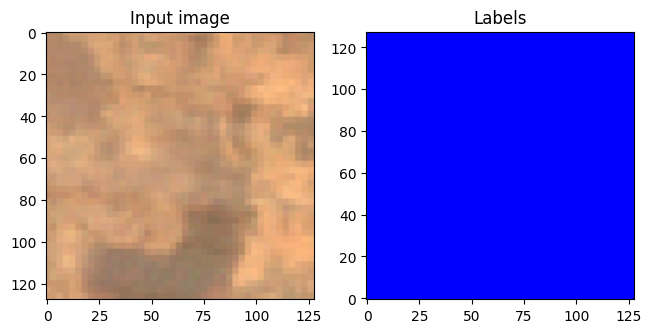

In [14]:
from visualize import show_patch


inputs = example['inputs']
labels = example['labels']

show_patch(inputs, labels)

How let's split the dataset into a train and test subset using the test_train_split function. Test differt ratios to see how the dataset splits and view the first of each.

Train size: 10
inputs: (128, 128, 4)
labels: (128, 128, 1)
Test size: 10
inputs: (128, 128, 4)
labels: (128, 128, 1)

Train[0]:


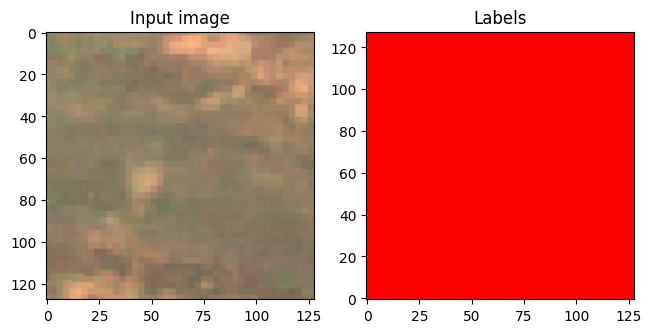

Test[0]:


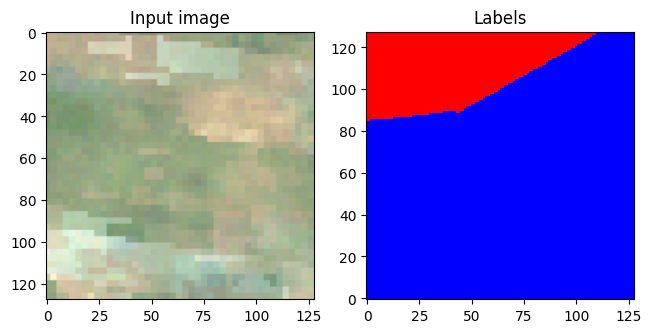

In [15]:
ratio = 0.5
train, test = test_train_split(dataset, ratio=0.5, seed=0)

print(f"Train size: {len(train)}")
train_example = train[0]  # random access the first element
print(f"inputs: {train_example['inputs'].shape}")
print(f"labels: {train_example['labels'].shape}")
print(f"Test size: {len(train)}")
test_example = test[0]  # random access the first element
print(f"inputs: {test_example['inputs'].shape}")
print(f"labels: {test_example['labels'].shape}\n")

train_inputs = train_example['inputs']
train_labels = train_example['labels']
test_inputs = test_example['inputs']
test_labels = test_example['labels']
print(f'Train[0]:')
show_patch(train_inputs, train_labels)
print(f'Test[0]:')
show_patch(test_inputs, test_labels)

### Test access: Statistics

I'm just testing to make sure we can access the data in the way we want... haven't checked for proper use of np.mean().

In [16]:
from torch.utils.data.dataloader import DataLoader
# future
import numpy as np

print(type(dataset['inputs']))
print(train['inputs'].shape)
data = train['inputs']
mean = data.mean(axis=(0, 1, 2))[None, None, None, :]
std = data.std(axis=(0, 1, 2))[None, None, None, :]

print(f'Train inputs mean: {mean.shape}')
print(f'Train inputs std: {std.shape}')

<class 'numpy.ndarray'>
(10, 128, 128, 4)
Train inputs mean: (1, 1, 1, 4)
Train inputs std: (1, 1, 1, 4)


# Model



1.   Define the model
2.   Train (locally or with VertexAI)




## Define the model

To start, we're going to implement a simple FCN to demo the workflow.

In [17]:
class Normalization(torch.nn.Module):
    """Preprocessing normalization layer with z-score."""

    def __init__(self, mean: AnyType, std: AnyType) -> None:
        super().__init__()
        self.mean = torch.nn.Parameter(torch.as_tensor(mean))
        self.std = torch.nn.Parameter(torch.as_tensor(std))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return (x - self.mean) / self.std

class MoveDim(torch.nn.Module):
    """Moves a dimension axis to another position."""

    def __init__(self, src: int, dest: int) -> None:
        super().__init__()
        self.src = src
        self.dest = dest

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.moveaxis(self.src, self.dest)

In [18]:
normalization = Normalization(mean, std)
sample = lambda x: x[0, 0, 0, 0:20].detach().numpy()

print(f"mean: {sample(normalization.mean)}")
print(f"std:  {sample(normalization.std)}")
print("-" * 40)

example = train[0]
example_inputs = torch.as_tensor([example["inputs"]])
normalized_inputs = normalization(example_inputs)
print(f"inputs:     {sample(example_inputs)}")
print(f"normalized: {sample(normalized_inputs)}")

mean: [1.3368165e+03 1.1080354e+03 8.4263757e+02 3.2418004e-01]
std:  [4.59987396e+02 2.60909027e+02 1.57014526e+02 1.12378724e-01]
----------------------------------------
inputs:     [1.0870000e+03 9.5800000e+02 6.8800000e+02 3.7956622e-01]
normalized: [-0.5430943  -0.5750487  -0.98486155  0.49285296]


<ipython-input-18-bf8b385e20ae>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  example_inputs = torch.as_tensor([example["inputs"]])


In [19]:
# We move the channels/last dimension (-1) to the second index (1),
# since the first (0) is for the batch dimension.
to_channels_first = MoveDim(-1, 1)
channels_first = to_channels_first(normalized_inputs)

print(f"normalized:     {normalized_inputs.shape}")
print(f"channels-first: {channels_first.shape}")

normalized:     torch.Size([1, 128, 128, 4])
channels-first: torch.Size([1, 4, 128, 128])


In [21]:
num_inputs = 4
num_hidden1 = 64
num_hidden2 = 128
kernel_size = (3, 3)

fully_convolutional_layers = torch.nn.Sequential(
    torch.nn.Conv2d(num_inputs, num_hidden1, kernel_size),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(num_hidden1, num_hidden2, kernel_size),
    torch.nn.ReLU(),
)

fcn_outputs = fully_convolutional_layers(channels_first)
print(f"FCN outputs: {fcn_outputs.shape}")

FCN outputs: torch.Size([1, 128, 128, 128])


In [22]:
to_channels_last = MoveDim(1, -1)
channels_last = to_channels_last(fcn_outputs)

print(f"channels-last: {channels_last.shape}")

channels-last: torch.Size([1, 128, 128, 128])


In [23]:
num_outputs = 2

linear = torch.nn.Linear(num_hidden2, num_outputs)
relu = torch.nn.ReLU()

with torch.no_grad():
    raw_predictions = linear(channels_last)
    predictions = relu(raw_predictions)

print(f"predictions: {predictions.shape}")
print(predictions[0, 0, 0])

predictions: torch.Size([1, 128, 128, 2])
tensor([0.0884, 0.0754])


# dd Unfinished work: Ignore

Currently testing: reading from created npz files and translating them into usable dataset objects

## Reading testing

In [ ]:
%cd /content/satellite_cnns

/content/satellite_cnns


In [ ]:
# on 4/20, the data was written to the bucket benin_export and folder experiment_3
# using the above code (which no longer works)
bucket = 'example-bucket-ls-3-24'
folder = 'dd_test'
gs_data_path=f"gs://{bucket}/{folder}/data"
print(gs_data_path)

gs://example-bucket-ls-3-24/dd_test/data


In [ ]:
!mkdir -p data-training
!gsutil -m cp {gs_data_path}/* data-training

Copying gs://example-bucket-ls-3-24/dd_test/data/2055e070-4f5a-4d17-a11a-8e7eeb297375.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/18c4fdf7-d37f-4e58-906c-7c2036c042ed.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/1f38f340-2d5c-4d7e-9a2a-769bf74a36cf.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/a0d6e5ef-0b81-45da-b185-83cbe38e564f.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/518dcc77-99b5-4f82-a697-3fc991f4a112.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/aa37e233-2639-40fd-bf65-7cdd45a183ef.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/6342b3bc-b2f4-4767-b8b1-de5f63d9ff1b.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/edac60dd-fbab-45ac-84eb-d768a6ebfe83.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/ca5962eb-84ef-4334-98c3-b95311d088bb.npz...
Copying gs://example-bucket-ls-3-24/dd_test/data/af755a1e-69e6-494a-b0ac-c9f1a16545c1.npz...
\ [10/10 files][314.7 KiB/314.7 KiB] 100% Done                        

In [ ]:
%ls data-training/

18c4fdf7-d37f-4e58-906c-7c2036c042ed.npz
1f38f340-2d5c-4d7e-9a2a-769bf74a36cf.npz
2055e070-4f5a-4d17-a11a-8e7eeb297375.npz
518dcc77-99b5-4f82-a697-3fc991f4a112.npz
6342b3bc-b2f4-4767-b8b1-de5f63d9ff1b.npz
a0d6e5ef-0b81-45da-b185-83cbe38e564f.npz
aa37e233-2639-40fd-bf65-7cdd45a183ef.npz
af755a1e-69e6-494a-b0ac-c9f1a16545c1.npz
ca5962eb-84ef-4334-98c3-b95311d088bb.npz
edac60dd-fbab-45ac-84eb-d768a6ebfe83.npz


In [ ]:
!pip install --quiet apache-beam[gcp] src/benin-data

In [ ]:
%mkdir /content/testing-data

In [ ]:
%ls /content/testing-data/

00fd89be-8b64-4117-b0ee-f418ba2e1b0f.npz
0e6c6bbe-162b-417a-9c3e-699710122e95.npz


In [ ]:
%rm -rf /content/testing-data/*.npz

In [ ]:
from create_dataset import write_npz, get_training_example

points = [[2.474858607749282, 12.03293323078099],
            [2.241296633878206, 11.197500016549837],
            [1.899936825912788, 7.325761141994698]]

test_file = write_npz([get_training_example(point) for point in points], "/content/testing-data")

In [ ]:
points = [[2.474858607749282, 12.03293323078099],
 [2.241296633878206, 11.197500016549837]]

test_file = test_file = write_npz([get_training_example(p) for p in points], "/content/testing-data")

## Data patch testing

In [ ]:
from benin.data import get_labels_image
from benin.data import sample_points

for point in sample_points(0, 2):
  print(point)

[2.474858607749282, 12.03293323078099]
[1.899936825912788, 7.325761141994698]
[2.241296633878206, 11.197500016549837]
[2.5826564418436244, 6.948468722664499]


In [ ]:
%cd /content/satellite_cnns


/content/satellite_cnns


In [ ]:
from create_dataset import get_training_example
point = [2.474858607749282, 12.03293323078099]
(inputs, labels) = get_training_example(point, patch_size=128)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

def show_plot(inputs_patch, labels_patch):

  inputs_visual = inputs_patch[:,:, :3]
  inputs_visual = inputs_visual/np.amax(inputs_visual)
  fig, axs = plt.subplots(1, 2, layout='constrained')

  cmap = colors.ListedColormap(['blue', 'red'])
  bounds=[0,1,2]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  #plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 5, 10])
  axs[0].imshow(inputs_visual)
  axs[1].imshow(labels_patch, origin='lower', interpolation='nearest', cmap=cmap, norm=norm)
  axs[0].set_title("Input image")
  axs[1].set_title("Labels")
  plt.show()

In [ ]:
for i in range(4):
  print(f"{inputs[i][:3]}\n")

[[1.65450000e+03 1.31650000e+03 9.65000000e+02 2.25511998e-01]
 [1.66450000e+03 1.28650000e+03 9.65000000e+02 2.10763395e-01]
 [1.66450000e+03 1.28650000e+03 9.65000000e+02 2.10763395e-01]]

[[1.64150000e+03 1.33050000e+03 1.00800000e+03 2.18798339e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]]

[[1.64150000e+03 1.33050000e+03 1.00800000e+03 2.18798339e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]]

[[1.64150000e+03 1.33050000e+03 1.00800000e+03 2.18798339e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]
 [1.66100000e+03 1.30050000e+03 9.69500000e+02 2.16878831e-01]]



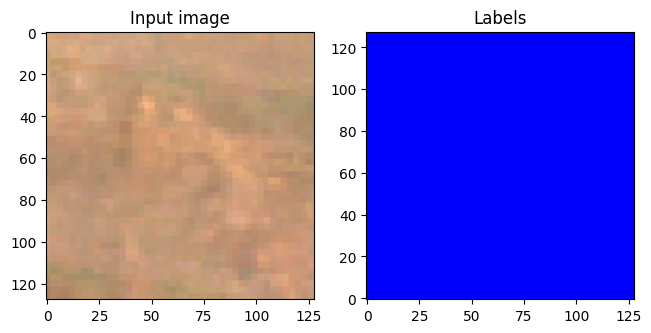

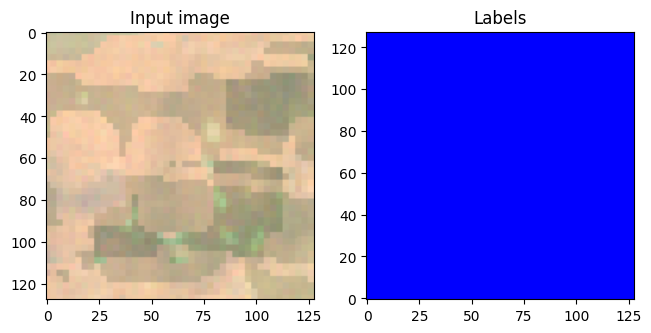

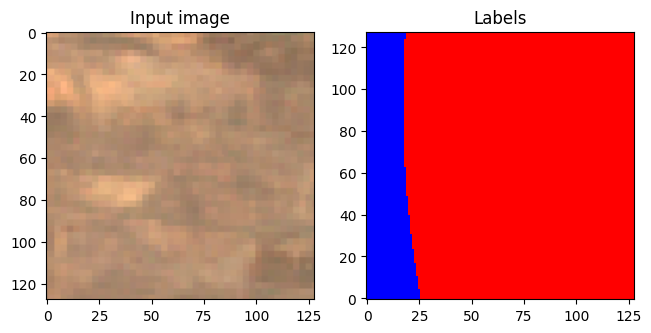

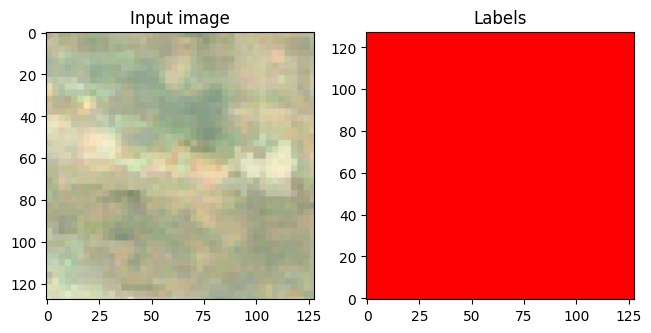

In [ ]:
for point in sample_points(0,2):
  (inputs, labels) = get_training_example(point, patch_size=128)
  show_plot(inputs)

In [ ]:
for point in sample_points(0,1):
  print(point)

[2.474858607749282, 12.03293323078099]
[2.241296633878206, 11.197500016549837]


## Serialize testing

Following code block from [tf_model.py](https://github.com/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/trainer/tf_model.py#L36) from original land-cover sample

In [ ]:
# coppied from

NUM_INPUTS = 13
NUM_CLASSES = 1


def read_dataset(data_path: str) -> tf.data.Dataset:
    """Reads compressed TFRecord files from a directory into a tf.data.Dataset.

    Args:
        data_path: Local or Cloud Storage directory path where the TFRecord files are.

    Returns: A tf.data.Dataset with the contents of the TFRecord files.
    """
    file_pattern = tf.io.gfile.join(data_path, "*.tfrecord.gz")
    file_names = tf.data.Dataset.list_files(file_pattern).cache()
    dataset = tf.data.TFRecordDataset(file_names, compression_type="GZIP")
    return dataset.map(read_example, num_parallel_calls=tf.data.AUTOTUNE)

def read_example(serialized: bytes) -> tuple[tf.Tensor, tf.Tensor]:
    """Parses and reads a training example from TFRecords.

    Args:
        serialized: Serialized example bytes from TFRecord files.

    Returns: An (inputs, labels) pair of tensors.
    """
    features_dict = {
        "inputs": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(serialized, features_dict)
    inputs = tf.io.parse_tensor(example["inputs"], tf.float32)
    labels = tf.io.parse_tensor(example["labels"], tf.uint8)

    # TensorFlow cannot infer the shape's rank, so we set the shapes explicitly.
    inputs.set_shape([None, None, NUM_INPUTS])
    labels.set_shape([None, None, 1])

    # Classifications are measured against one-hot encoded vectors.
    one_hot_labels = tf.one_hot(labels[:, :, 0], NUM_CLASSES)
    return (inputs, one_hot_labels)

Serialization seems to be working locally... unsure of why pipeline wouldn't have access to tf

In [ ]:
from create_dataset import serialize_tensorflow, get_training_example


point = [1.9046529811544155, 6.937464360434035]
(inputs, labels) = get_training_example(point)

serialized = serialize_tensorflow(inputs, labels)
print(f"serialized: {len(serialized)} bytes")

serialized: 655456 bytes


In [ ]:
#from trainer.tf_model import read_dataset
import numpy as np
import matplotlib.pyplot as plt
data_path = f"gs://example-bucket-ls-3-24/land-cover/data"
dataset = read_dataset(data_path)

for x, y in dataset.take(1):
  print("inputs:", x.dtype.name, x.shape)
  print("labels:", y.dtype.name, y.shape)

inputs: float32 (128, 128, 13)
labels: float32 (128, 128, 1)


## New pipeline testing

In [ ]:
from apache_beam.io.filesystems import FileSystems
from apache_beam.options.pipeline_options import PipelineOptions
import numpy as np
import uuid

def write_npz(batch: list[tuple[np.ndarray, np.ndarray]], data_path: str) -> str:
    """Writes an (inputs, labels) batch into a compressed NumPy file.

    Args:
        batch: Batch of (inputs, labels) pairs of NumPy arrays.
        data_path: Directory path to save files to.

    Returns: The filename of the data file.
    """
    filename = FileSystems.join(data_path, f"{uuid.uuid4()}.npz")
    with FileSystems.create(filename) as f:
        inputs = [x for (x, _) in batch]
        labels = [y for (_, y) in batch]
        np.savez_compressed(f, inputs=inputs, labels=labels)
    return filename

In [ ]:
bucket = 'example-bucket-ls-3-24'
folder = 'dd_test'
data_path=f"gs://{bucket}/{folder}/data"

PATCH_SIZE = 128
MAX_REQUESTS = 20
POINTS_PER_CLASS = 3 # small for testing purposes

In [ ]:
data_path

'gs://example-bucket-ls-3-24/dd_test/data'

In [ ]:
!pip install apache-beam[interactive]

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from benin.data import sample_points

beam_options = PipelineOptions([])


with beam.Pipeline(options=beam_options) as pipeline:
   (
      pipeline
      | "🌱 Make seeds" >> beam.Create([0])
      | "🛰 Sample points" >> beam.FlatMap(sample_points)
      | "🃏 Reshuffle" >> beam.Reshuffle()
      | "📖 Get examples" >> beam.Map(get_training_example)
      | "🗂️ Batch examples" >> beam.BatchElements()
      | "📝 Write NPZ files" >> beam.Map(write_npz, data_path)
  )

In [ ]:
!gsutil ls -lh gs://{bucket}/{folder}/data

 24.74 KiB  2023-07-03T02:47:51Z  gs://example-bucket-ls-3-24/dd_test/data/18c4fdf7-d37f-4e58-906c-7c2036c042ed.npz
 24.74 KiB  2023-07-03T02:43:08Z  gs://example-bucket-ls-3-24/dd_test/data/518dcc77-99b5-4f82-a697-3fc991f4a112.npz
  27.2 KiB  2023-07-03T02:47:20Z  gs://example-bucket-ls-3-24/dd_test/data/a0d6e5ef-0b81-45da-b185-83cbe38e564f.npz
 52.79 KiB  2023-07-03T02:44:04Z  gs://example-bucket-ls-3-24/dd_test/data/aa37e233-2639-40fd-bf65-7cdd45a183ef.npz
  27.2 KiB  2023-07-03T02:42:39Z  gs://example-bucket-ls-3-24/dd_test/data/af755a1e-69e6-494a-b0ac-c9f1a16545c1.npz
 52.79 KiB  2023-07-03T02:48:53Z  gs://example-bucket-ls-3-24/dd_test/data/edac60dd-fbab-45ac-84eb-d768a6ebfe83.npz
TOTAL: 6 objects, 214464 bytes (209.44 KiB)
